Setup

In [3]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import torch
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds")

model_id = "google/owlv2-base-patch16"
device = torch.device("cpu")
print("Using device:", device)

# Load model AFTER checking device
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

Using device: cpu


Load OwlV2 Model

Preview dataset

In [4]:
DATASET_PATH = "dataset/20250327_091546_df_all_2.pkl"
df = pd.read_pickle(DATASET_PATH)
df.info()
df['filename'].unique()[:10]

# Get top N most common labels for testing
top_labels = df['label'].value_counts().head(20).index.tolist()
print("Most common prompts:", top_labels)

# Counter of every label
df['label'].value_counts()

def compute_iou(box1, box2):
    xa, ya = max(box1[0], box2[0]), max(box1[1], box2[1])
    xb, yb = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, xb - xa) * max(0, yb - ya)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0




<class 'pandas.core.frame.DataFrame'>
Index: 25611 entries, 0 to 27260
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bbox          25611 non-null  object 
 1   category_id   25611 non-null  int64  
 2   image_id      25611 non-null  int64  
 3   id            25611 non-null  int64  
 4   segmentation  25611 non-null  object 
 5   area          25611 non-null  float64
 6   label         25611 non-null  object 
 7   set           25611 non-null  object 
 8   filename      25611 non-null  object 
 9   split         25611 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.1+ MB
Most common prompts: ['cabinet', 'knob', 'handle', 'drawer', 'cushion', 'vase', 'pillow', 'chair', 'bottle', 'doorknob', 'curtain', 'flowerpot', 'cupboard', 'pole', 'hinge', 'lamp', 'painting', 'signboard', 'glass_(drink_container)', 'candle']


Extract needed filenames from dataset

In [5]:
# Load your dataset
import pandas as pd
df = pd.read_pickle("dataset/20250327_091546_df_all_2.pkl")
filenames = df['filename'].unique()


Download only matching files from COCO (2881)

In [ ]:
import requests
from tqdm import tqdm

DEST_FOLDER = "dataset/images"
os.makedirs(DEST_FOLDER, exist_ok=True)

for fname in tqdm(filenames):
    img_id = fname.split('.')[0]
    url = f"http://images.cocodataset.org/train2017/{fname}"
    dest = os.path.join(DEST_FOLDER, fname)

    if not os.path.exists(dest):
        try:
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(dest, 'wb') as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
        except Exception as e:
            print(f"Failed to download {fname}: {e}")


# Processing Dataset


In [6]:
import os
import json
from tqdm import tqdm
from PIL import Image
import torch
from PIL import ImageFile

# CONFIGURATION
DEST_FOLDER = "dataset/images"
os.makedirs(DEST_FOLDER, exist_ok=True)
SAMPLE_FILE = "sampled_filenames.json"
RESULTS_FILE = "results_cached.json"
BOX_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5

ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Utility function
def normalize_label(label):
    """Convert underscores to spaces and strip whitespace."""
    return label.replace("_", " ").strip()

# === Step 1: Use all images and all labels from the metadata
sampled_filenames = sorted(df['filename'].unique().tolist())   # All unique filenames (all 2881)
base_labels = sorted(df['label'].unique().tolist())            # All unique labels in metadata
base_labels = [normalize_label(lbl) for lbl in base_labels]    # Normalize: underscores -> spaces

prompts = base_labels   # Use all normalized labels as prompts

# Save the full list (optional)
with open(SAMPLE_FILE, "w") as f:
    json.dump(sampled_filenames, f)  

# === Step 2: Run inference and build results
if os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, "r") as f:
        results = json.load(f)
    print(f"✅ Loaded cached results from {RESULTS_FILE}")
else:
    results = []
    for fname in tqdm(sampled_filenames, desc="Processing images"):
        img_path = os.path.join(DEST_FOLDER, fname)
        if not os.path.exists(img_path):
            continue

        # Load image
        image = Image.open(img_path).convert("RGB")
        annots = df[df['filename'] == fname]

        # Run OWL-V2
        inputs = processor(images=image, text=prompts, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process detections
        target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
        detections = processor.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=BOX_THRESHOLD
        )[0]

        # Loop through each detected box
        for score, label_idx, box in zip(detections['scores'], detections['labels'], detections['boxes']):
            predicted_label = prompts[label_idx]
            pred_box = box.tolist()
            matched = False
            best_iou = 0.0

            # Match to GT boxes
            for _, row in annots[annots['label'] == predicted_label].iterrows():
                gt_x, gt_y, gt_w, gt_h = row['bbox']
                gt_box = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
                iou = compute_iou(pred_box, gt_box)
                best_iou = max(best_iou, iou)
                if iou >= IOU_THRESHOLD:
                    matched = True
                    break

            results.append({
                "image": fname,
                "prompt": predicted_label,
                "label": predicted_label,
                "score": round(score.item(), 3),
                "matched": int(matched),
                "iou_value": round(best_iou, 3),
                "box": pred_box
            })

    # Save results
    with open(RESULTS_FILE, "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ Saved {len(results)} detections to {RESULTS_FILE}")


✅ Loaded cached results from results_cached.json


# Evaluation 

Ground truth + Results cleaned function for quantitative metrics

In [40]:
ground_truths = []
for fname in sampled_filenames:
    gt_list = []
    temp_df = df[df["filename"] == fname]
    gt_labels_in_img = temp_df["label"].unique()
    for lbl in gt_labels_in_img:
        count = temp_df[temp_df["label"] == lbl].shape[0]
        gt_list.append({"label": lbl, "quantity": int(count)})
    ground_truths.append(gt_list)

results_cleaned = []
df_results = pd.DataFrame(results)
grouped = df_results.groupby(["image", "label"]).size().reset_index(name="quantity")
for fname in sampled_filenames:
    preds = []
    temp_df = grouped[grouped["image"] == fname]
    # Use only GT labels present in this image
    gt_labels_in_img = df[df["filename"] == fname]["label"].unique()
    for lbl in gt_labels_in_img:
        count = temp_df[temp_df["label"] == lbl]["quantity"].sum()
        preds.append({"label": lbl, "quantity": int(count)})
    results_cleaned.append(preds)

Quantitative Metrics 

In [41]:
def quantity_metrics(results_cleaned, ground_truths):
    """
    Custom OWL-V2 quantity evaluation metrics.

    Only label-image pairs where both the ground truth (GT) and the prediction are greater than zero
    are included in the evaluation. Pairs where either value is zero are ignored.

    Metrics:
    #1 Per-image Average Accuracy: Mean of prediction-to-GT ratios per label, averaged per image.
    #2 Per-class Quantity-weighted Accuracy: For each class, averages the prediction-to-GT ratios weighted by GT quantity; then averages across all classes.
    #3 Overall Micro-average Accuracy: Average prediction-to-GT ratio across all included label-image pairs.

    All metrics use the ratio min(pred / GT, GT / pred), which is 1 for a perfect match and approaches 0 as the prediction diverges from the ground truth.
    """

    assert len(ground_truths) == len(results_cleaned)
    list_scores = []
    for idx in range(len(ground_truths)):
        gt_df = pd.DataFrame(ground_truths[idx])
        if not results_cleaned[idx]:
            pred_df = pd.DataFrame(columns=["label", "quantity"])
        else:
            pred_df = pd.DataFrame(results_cleaned[idx])
        idx_scores = []
        for _, gt_row in gt_df.iterrows():
            label = gt_row['label']
            qty_gt = gt_row['quantity']
            qty_pred = 0
            if not pred_df[pred_df['label'] == label].empty:
                qty_pred = pred_df[pred_df['label'] == label]['quantity'].sum()
            # Only include if both quantities are positive
            if qty_gt > 0 and qty_pred > 0:
                ratio = min(qty_gt / qty_pred, qty_pred / qty_gt)
                idx_scores.append({
                    "label": label,
                    "ratio": ratio,
                    "gt_quantity": qty_gt
                })
            # else: skip, do not append
        list_scores.append(idx_scores)

    # Metric 1: Image + Label Equi-weighted (average only over present scores)
    per_img_means = [sum(x['ratio'] for x in img) / len(img) for img in list_scores if img]
    mean_score_1 = sum(per_img_means) / len(per_img_means) if per_img_means else 0

    # Metric 2: Quantity-weighted per class (average only over included pairs)
    class_weighted_scores = {}
    for img_scores in list_scores:
        for item in img_scores:
            label = item['label']
            ratio = item['ratio']
            weight = item['gt_quantity']
            if label not in class_weighted_scores:
                class_weighted_scores[label] = {'total_ratio': 0, 'total_qty': 0}
            class_weighted_scores[label]['total_ratio'] += ratio * weight
            class_weighted_scores[label]['total_qty'] += weight
    dict_class_scores_2 = {}
    for label, v in class_weighted_scores.items():
        avg = v['total_ratio'] / v['total_qty'] if v['total_qty'] else 0.0
        dict_class_scores_2[label] = round(avg, 4)
    mean_score_2 = (
        sum(dict_class_scores_2.values()) / len(dict_class_scores_2) if dict_class_scores_2 else 0
    )

    # Metric 3: Micro-average across all image-label pairs (included pairs only)
    all_ratios = [x['ratio'] for img in list_scores for x in img]
    mean_score_3 = sum(all_ratios) / len(all_ratios) if all_ratios else 0

    return (
        list_scores,
        mean_score_1,
        dict_class_scores_2,
        mean_score_2,
        mean_score_3,
        per_img_means
    )

# Usage:
(
    list_scores, 
    mean_score_1, 
    dict_class_scores_2, 
    mean_score_2, 
    mean_score_3,
    img_scores
) = quantity_metrics(results_cleaned, ground_truths)

print("Quantitative Metrics :")
print("----------------")
print("METRIC 1: Image + Label Equi-weighted")
print("mean_score_1:", round(mean_score_1, 4))
print("----------------")
print("METRIC 2: Quantity-weighted per class")
print("mean_score_2:", round(mean_score_2, 4))
print("class scores:", dict_class_scores_2)
print("----------------")
print("METRIC 3: Micro-average across all image-label pairs")
print("mean_score_3:", round(mean_score_3, 4))


Quantitative Metrics :
----------------
METRIC 1: Image + Label Equi-weighted
mean_score_1: 0.7346
----------------
METRIC 2: Quantity-weighted per class
mean_score_2: 0.6385
class scores: {'blackboard': np.float64(0.6944), 'wineglass': np.float64(0.544), 'clock': np.float64(0.8254), 'pot': np.float64(0.5195), 'knob': np.float64(0.5211), 'hook': np.float64(0.2898), 'chandelier': np.float64(0.6404), 'cornice': np.float64(0.6581), 'bed': np.float64(0.8356), 'fan': np.float64(0.7783), 'bell': np.float64(0.4139), 'desk': np.float64(0.5117), 'billboard': np.float64(0.2376), 'drawer': np.float64(0.4144), 'curtain': np.float64(0.6326), 'dispenser': np.float64(0.5714), 'sink': np.float64(0.7761), 'pole': np.float64(0.4089), 'refrigerator': np.float64(0.8117), 'flag': np.float64(0.5228), 'tablecloth': np.float64(0.7108), 'stove': np.float64(0.734), 'vent': np.float64(0.5469), 'bowl': np.float64(0.4667), 'toilet': np.float64(0.7321), 'pipe': np.float64(0.4385), 'bathtub': np.float64(0.7344), 'ba

# Visualization 

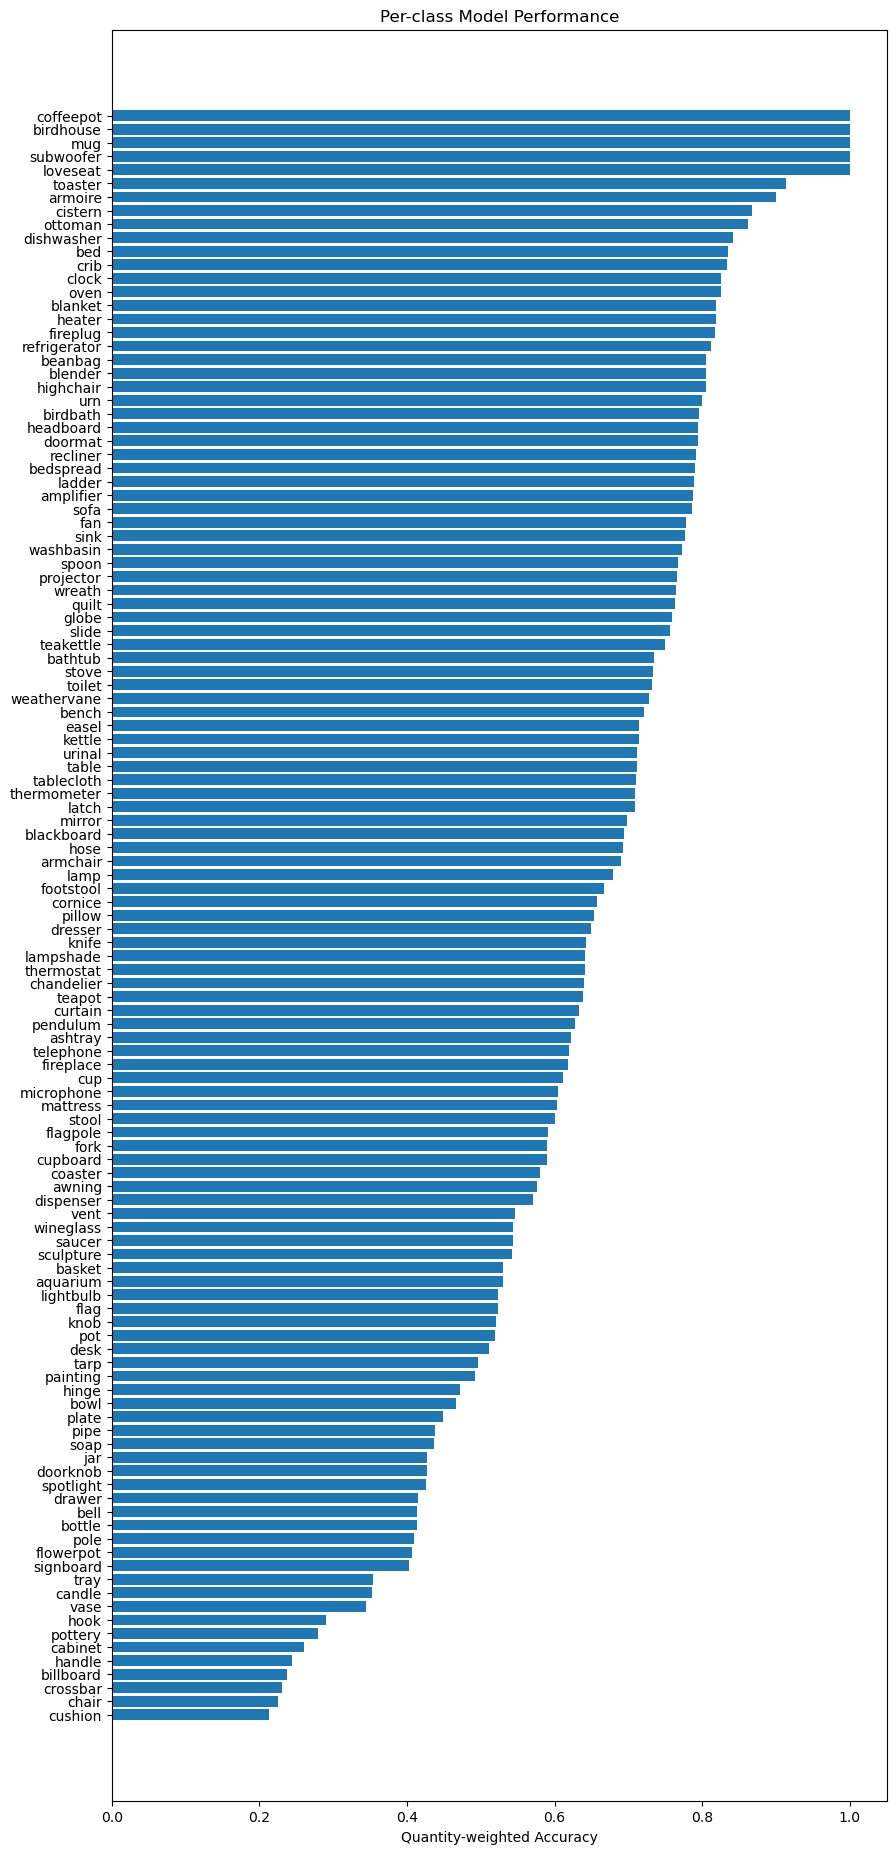

In [9]:
# Bar plot for per-class performance
class_scores = dict_class_scores_2 
labels, scores = zip(*sorted(class_scores.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, max(4, len(labels)//5)))
plt.barh(labels, scores)
plt.xlabel("Quantity-weighted Accuracy")
plt.title("Per-class Model Performance")
plt.gca().invert_yaxis()
plt.show()


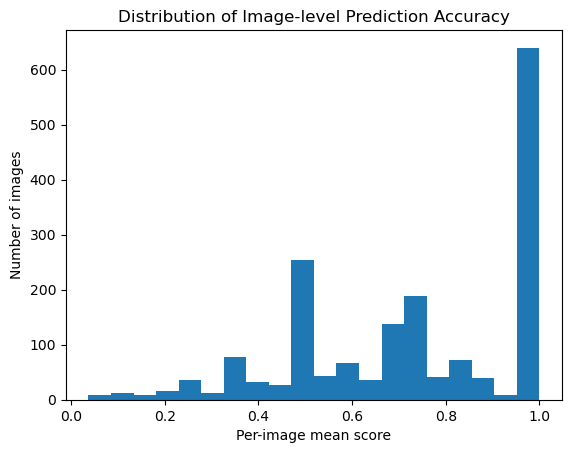

In [10]:
# Distribution of per-image mean scores
plt.hist(img_scores, bins=20)
plt.xlabel("Per-image mean score")
plt.ylabel("Number of images")
plt.title("Distribution of Image-level Prediction Accuracy")
plt.show()

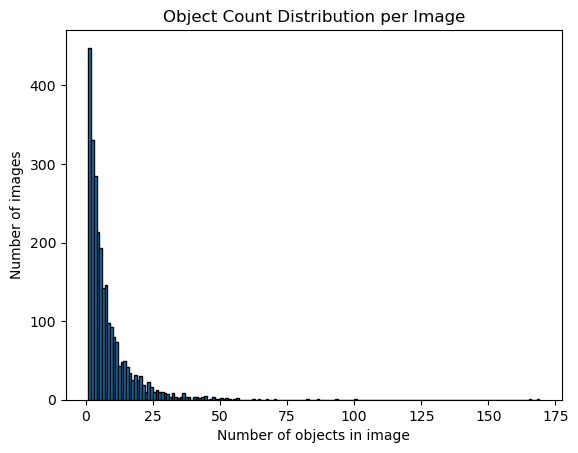

In [11]:
object_counts = [sum(obj['quantity'] for obj in img) for img in ground_truths]
plt.hist(object_counts, bins=range(1, max(object_counts)+2), edgecolor='black')
plt.xlabel("Number of objects in image")
plt.ylabel("Number of images")
plt.title("Object Count Distribution per Image")
plt.show()

In [12]:
# Load your result_cached.json file
with open("results_cached.json", "r") as f:
    all_preds = json.load(f)  # List of dicts

# Build image name to index mapping (so we can put each pred in the right slot)
imgname_to_idx = {os.path.basename(p): idx for idx, p in enumerate(sampled_filenames)}

# Prepare an empty list for each image (matching image_paths)
results_cleaned_bboxes = [[] for _ in range(len(sampled_filenames))]

# Fill in results_cleaned_bboxes
for pred in all_preds:
    imgname = pred['image']  # e.g., "000000000308.jpg"
    idx = imgname_to_idx.get(imgname)
    if idx is not None:
        pred_obj = {
            'label': pred['label'],
            'bbox': pred['box'],
            'score': pred['score']
        }
        results_cleaned_bboxes[idx].append(pred_obj)

# Sanity check: see a few predictions for the first image
print(results_cleaned_bboxes[0])  # List of dicts with label, bbox, score


[{'label': 'hose', 'bbox': [475.4208679199219, 1.6723060607910156, 578.2288818359375, 190.6536865234375], 'score': 0.476}, {'label': 'awning', 'bbox': [284.82904052734375, 66.33013916015625, 339.58978271484375, 90.2752685546875], 'score': 0.477}, {'label': 'blackboard', 'bbox': [284.4021301269531, 93.6373062133789, 312.61944580078125, 151.6987762451172], 'score': 0.52}, {'label': 'pole', 'bbox': [315.078125, 84.6316146850586, 335.57403564453125, 134.47679138183594], 'score': 0.302}, {'label': 'wineglass', 'bbox': [148.31234741210938, 156.51263427734375, 188.663818359375, 252.23849487304688], 'score': 0.509}, {'label': 'hose', 'bbox': [405.6368408203125, 162.28970336914062, 441.987060546875, 176.19247436523438], 'score': 0.384}, {'label': 'wineglass', 'bbox': [234.0730438232422, 147.7456512451172, 260.80804443359375, 210.759033203125], 'score': 0.496}, {'label': 'hose', 'bbox': [372.16607666015625, 162.81954956054688, 446.240234375, 251.4344482421875], 'score': 0.344}, {'label': 'winegl

# Error Analysis

In [13]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score

# === Configuration ===
RESULTS_FILE = "results_cached.json"
CONFIDENCE_THRESHOLD = 0.3

# === Load Detection Results ===
with open(RESULTS_FILE, "r") as f:
    results = json.load(f)

eval_df = pd.DataFrame(results)

# === Check Data
if eval_df.empty:
    raise ValueError("⚠️ No detection results found.")

# === Filter and Preprocess
eval_df['matched'] = eval_df['matched'].astype(int)
eval_df = eval_df[eval_df['score'] >= CONFIDENCE_THRESHOLD].copy()

# Check for label column from processing step
if 'label' not in eval_df.columns:
    raise ValueError("❌ Missing 'label' column in result JSON. Ensure it was included during processing.")

# Ensure labels are clean
eval_df = eval_df.dropna(subset=['label'])
print(f"✅ Using {len(eval_df)} filtered detections with confidence ≥ {CONFIDENCE_THRESHOLD}")

# === Load Ground Truth Annotation Counts (df must be defined)
if 'df' not in globals():
    raise ValueError("❌ Ground truth annotations DataFrame `df` is not defined.")

# Count ground truth instances per class
gt_counts = df.groupby('label')['bbox'].count().to_dict()

# === Metric Computation Function ===
def compute_metrics(group):
    label = group.name
    total_gt = gt_counts.get(label, 0)
    tp = group['matched'].sum()
    fp = len(group) - tp
    fn = max(total_gt - tp, 0)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / total_gt if total_gt > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    try:
        ap = average_precision_score(group['matched'], group['score'])
        ap = round(ap, 3)
    except ValueError:
        ap = np.nan  # no valid positives

    mean_iou = round(group['iou_value'].mean(), 3)

    return pd.Series({
        'ground_truth': total_gt,
        'detections': len(group),
        'true_positives': tp,
        'false_positives': fp,
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'F1': round(f1, 3),
        'AP': ap,
        'mean_iou': mean_iou
    })

# === Apply Evaluation Per Label
summary = eval_df.groupby('label', group_keys=False).apply(compute_metrics).reset_index()
#summary = eval_df.groupby('prompt', group_keys=False).apply(compute_metrics).reset_index()

# === Compute mAP
map_value = summary['AP'].dropna().mean() if 'AP' in summary.columns else 0

# === Output Results
print("\n📊 Evaluation Summary:")
print(summary.to_string(index=False))

print(f"\n🔍 Overall mAP: {round(map_value, 3)}")

# === Optional: Save summary to CSV
# summary.to_csv("evaluation_summary.csv", index=False)

✅ Using 26499 filtered detections with confidence ≥ 0.3

📊 Evaluation Summary:
                                        label  ground_truth  detections  true_positives  false_positives  precision  recall    F1    AP  mean_iou
                              air conditioner           0.0        64.0             0.0             64.0      0.000   0.000 0.000 0.000     0.000
                                    amplifier          19.0        27.0             7.0             20.0      0.259   0.368 0.304 0.848     0.243
                                     aquarium          29.0        34.0            20.0             14.0      0.588   0.690 0.635 0.726     0.585
                                     armchair         154.0       120.0            54.0             66.0      0.450   0.351 0.394 0.609     0.399
                                      armoire          12.0       130.0             9.0            121.0      0.069   0.750 0.127 0.291     0.059
                                      ashtray

C:\Users\User\AppData\Local\Temp\ipykernel_13844\3229754662.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = eval_df.groupby('label', group_keys=False).apply(compute_metrics).reset_index()


In [14]:
# Rename eval_df['image'] to 'filename' for consistency
eval_df = eval_df.rename(columns={'image': 'filename'})

# Count GT objects per image per class
gt_counts_per_img_cls = df.groupby(['filename', 'label']).size().reset_index(name='gt_count')

# Count predicted objects per image per class
pred_counts_per_img_cls = eval_df.groupby(['filename', 'label']).size().reset_index(name='pred_count')

# Merge counts, fill missing as 0 (captures FNs/FPs)
count_comparison = pd.merge(gt_counts_per_img_cls, pred_counts_per_img_cls,
                            on=['filename', 'label'], how='outer').fillna(0)

# Compute absolute error per image/class
count_comparison['abs_count_error'] = (count_comparison['gt_count'] - count_comparison['pred_count']).abs()

# --- Summary Metrics ---

# 1. Mean absolute count error per (image, class)
mean_abs_count_error = count_comparison['abs_count_error'].mean()
print(f"Mean absolute count error per image/class: {mean_abs_count_error:.3f}")

# 2. Per-class mean absolute count error
per_class_count_error = count_comparison.groupby('label')['abs_count_error'].mean()
print("\nPer-class mean absolute count error:")
print(per_class_count_error.sort_values(ascending=False))

# 3. Per-image total absolute count error (all classes summed)
per_image_count_error = count_comparison.groupby('filename')['abs_count_error'].sum()
print("\nPer-image total absolute count error (all classes):")
print(per_image_count_error.describe())

# 4. Proportion of (image, class) pairs with perfect count (zero error)
perfect_counts = (count_comparison['abs_count_error'] == 0).sum()
total_cases = len(count_comparison)
perfect_count_rate = perfect_counts / total_cases if total_cases > 0 else 0
print(f"\nProportion of (image, class) cases with perfect counts: {perfect_count_rate:.2%}")

Mean absolute count error per image/class: 1.845

Per-class mean absolute count error:
label
pew_(church_bench)    13.733333
deck_chair             6.461538
cushion                6.393162
handle                 5.848485
cabinet                4.801887
                        ...    
bed                    0.816327
cistern                0.798077
fan                    0.794872
refrigerator           0.741758
crib                   0.680000
Name: abs_count_error, Length: 231, dtype: float64

Per-image total absolute count error (all classes):
count    2881.000000
mean       14.653940
std        13.428954
min         0.000000
25%         5.000000
50%        11.000000
75%        20.000000
max       165.000000
Name: abs_count_error, dtype: float64

Proportion of (image, class) cases with perfect counts: 6.88%


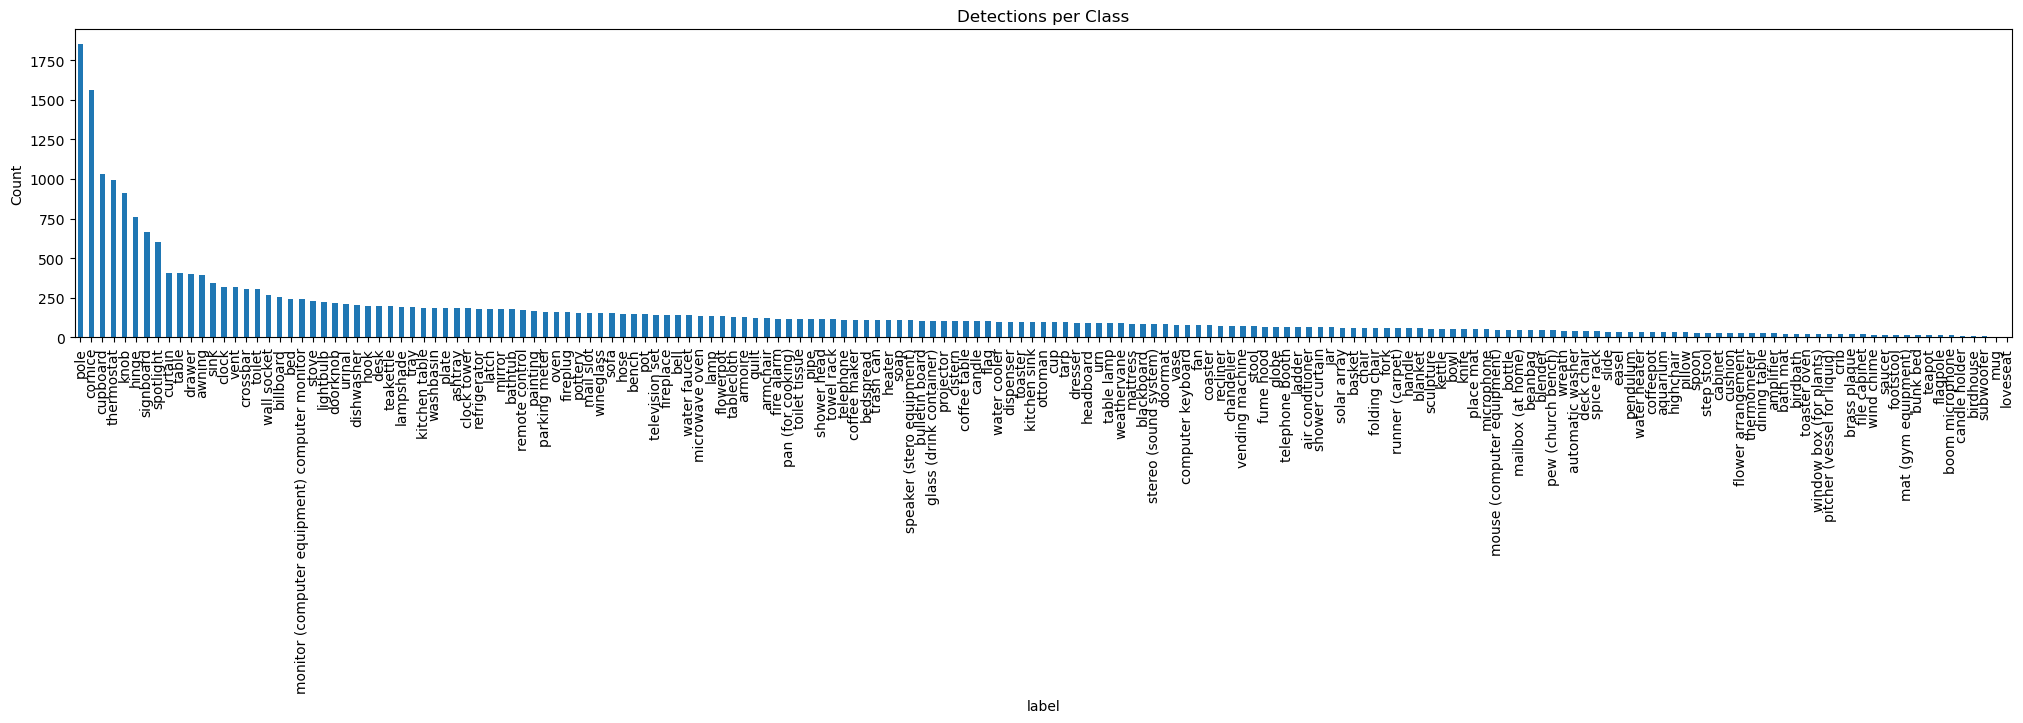

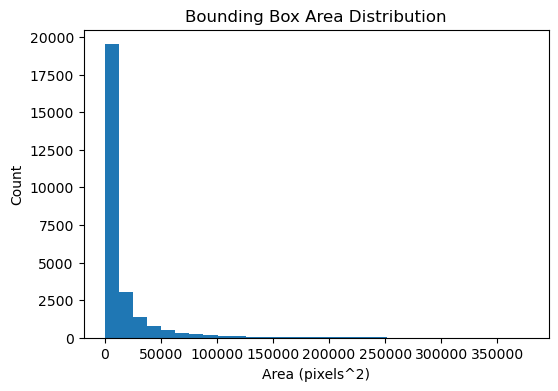

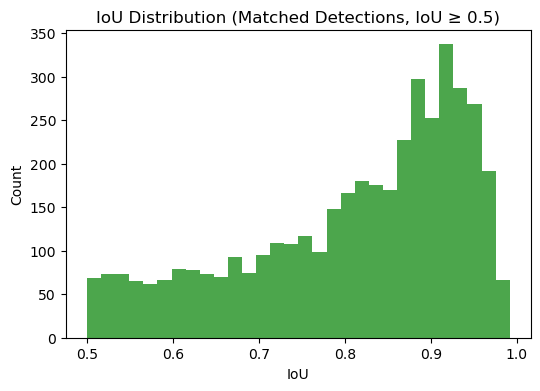

Number of detections with 0.3 ≤ IoU < 0.5: 705


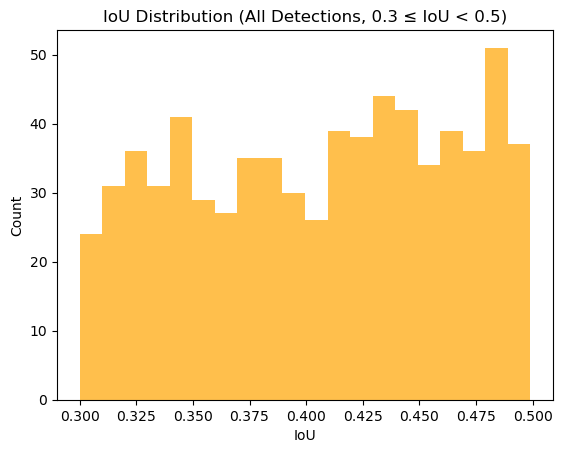

Detections with IoU near threshold (0.5±0.1): 414


In [15]:
# --- 1. Distribution Analysis ---

# a) Per-class detection count
det_counts = pd.DataFrame(results).groupby('label')['matched'].count().sort_values(ascending=False)
plt.figure(figsize=(25,4))
det_counts.plot(kind='bar')
plt.title('Detections per Class')
plt.ylabel('Count')
plt.show()

# b) Bounding box size distribution
all_boxes = [r['box'] for r in results]
box_areas = [(b[2]-b[0])*(b[3]-b[1]) for b in all_boxes]
plt.figure(figsize=(6,4))
plt.hist(box_areas, bins=30)
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Count')
plt.show()

# c) IoU distribution for matched detections (IoU ≥ 0.5)
ious = [r['iou_value'] for r in results if r['matched']]
plt.figure(figsize=(6,4))
plt.hist(ious, bins=30, color='g', alpha=0.7)
plt.title('IoU Distribution (Matched Detections, IoU ≥ 0.5)')
plt.xlabel('IoU')
plt.ylabel('Count')
plt.show()

# d) IoU distribution for borderline matches (0.3 ≤ IoU < 0.5)
all_ious = [r['iou_value'] for r in results]
borderline_ious = [iou for iou in all_ious if 0.3 <= iou < 0.5]
print(f"Number of detections with 0.3 ≤ IoU < 0.5: {len(borderline_ious)}")
plt.hist(borderline_ious, bins=20, color='orange', alpha=0.7)
plt.title('IoU Distribution (All Detections, 0.3 ≤ IoU < 0.5)')
plt.xlabel('IoU')
plt.ylabel('Count')
plt.show()

# e) IoU values near threshold
IOU_THRESHOLD = 0.5  # or your actual threshold
near_thresh = [iou for iou in ious if IOU_THRESHOLD-0.1 < iou < IOU_THRESHOLD+0.1]
print(f"Detections with IoU near threshold ({IOU_THRESHOLD}±0.1): {len(near_thresh)}")

In [23]:
# --- 2. False Negatives (FN) Analysis ---

# Find all GT boxes not matched by any prediction
def get_gt_boxes(df, fname):
    return [
        {'label': row['label'], 'bbox': [row['bbox'][0], row['bbox'][1], row['bbox'][0]+row['bbox'][2], row['bbox'][1]+row['bbox'][3]]}
        for _, row in df[df['filename']==fname].iterrows()
    ]

false_negatives = []
for idx, fname in enumerate(sampled_filenames):
    gt_boxes = get_gt_boxes(df, fname)
    preds = results_cleaned_bboxes[idx]
    for gt in gt_boxes:
        found = False
        for pred in preds:
            if pred['label'] == gt['label']:
                iou = compute_iou(pred['bbox'], gt['bbox'])
                if iou >= IOU_THRESHOLD:
                    found = True
                    break
        if not found:
            false_negatives.append({'image': fname, 'label': gt['label'], 'bbox': gt['bbox']})

print(f"Total False Negatives (missed objects): {len(false_negatives)}")

# --- 3. False Positives (FP) Analysis ---

false_positives = []
for idx, fname in enumerate(sampled_filenames):
    gt_boxes = get_gt_boxes(df, fname)
    gt_labels = set([gt['label'] for gt in gt_boxes])  # Only consider FPs for GT classes present in this image
    preds = results_cleaned_bboxes[idx]
    for pred in preds:
        # Only consider as FP if the predicted label is in the GT labels for this image
        if pred['label'] not in gt_labels:
            continue  # Ignore predictions for classes not annotated in this image
        matched = False
        for gt in gt_boxes:
            if pred['label'] == gt['label']:
                iou = compute_iou(pred['bbox'], gt['bbox'])
                if iou >= IOU_THRESHOLD:
                    matched = True
                    break
        if not matched:
            false_positives.append({'image': fname, 'label': pred['label'], 'bbox': pred['bbox'], 'score': pred['score']})
            
print(f"Total False Positives: {len(false_positives)}")


Total False Negatives (missed objects): 21742
Total False Positives: 1914


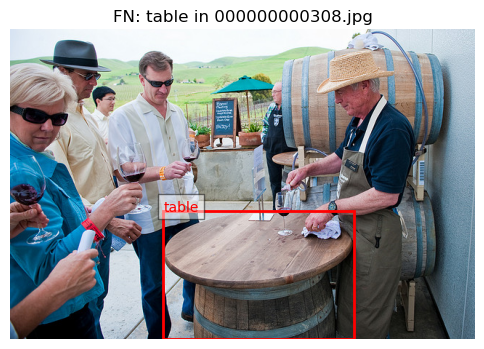

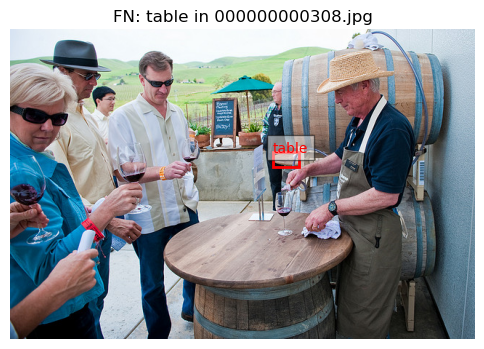

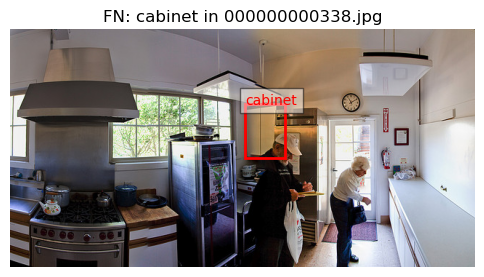

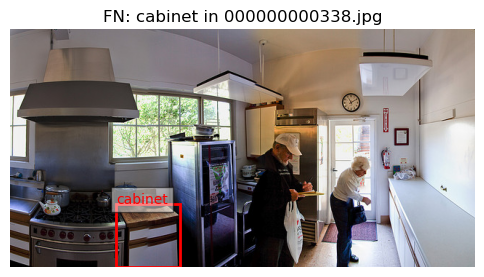

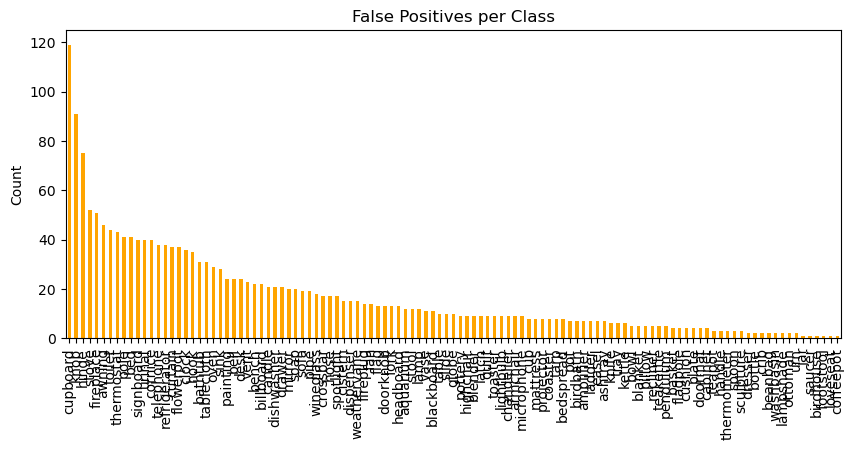

In [30]:
# --- 4. Visualize Examples of FPs and FNs ---
# Red boxes (FN) - object failed to detect
# Blue boxes (FP) - object detected but not in GT
def plot_image_with_boxes(image_path, boxes, color='r', title=''):
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    ax = plt.gca()
    for b in boxes:
        x0, y0, x1, y1 = b['bbox']
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0, b['label'], color=color, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show a few FN examples
for fn in false_negatives[:4]:
    img_path = os.path.join('dataset/images', fn['image'])
    plot_image_with_boxes(img_path, [fn], color='r', title=f"FN: {fn['label']} in {fn['image']}")

# Show a few FP examples
for fp in false_positives[:0]:
    img_path = os.path.join('dataset/images', fp['image'])
    plot_image_with_boxes(img_path, [fp], color='b', title=f"FP: {fp['label']} in {fp['image']}")

# --- 5. Additional: Analyze FPs by type (localization, duplicate, confusion) ---

# Example: Count FPs by label
fp_labels = pd.Series([fp['label'] for fp in false_positives])
plt.figure(figsize=(10,4))
fp_labels.value_counts().plot(kind='bar', color='orange')
plt.title('False Positives per Class')
plt.ylabel('Count')
plt.show()

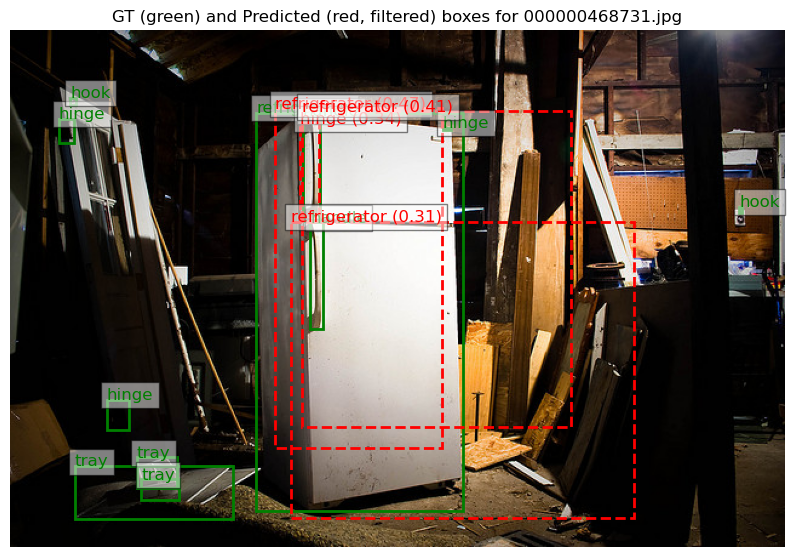

In [39]:
# Visualise GT vs Predicted boxes for a specific image
# --- Load predictions ---
with open("results_cached.json", "r") as f:
    preds = json.load(f)

img_name = "000000468731.jpg"
img_path = f"dataset/images/{img_name}"

# --- Get GT boxes ---
gt_rows = df[df['filename'] == img_name]
gt_boxes = []
gt_label_set = set()
for _, row in gt_rows.iterrows():
    x, y, w, h = row['bbox']
    gt_boxes.append({'bbox': [x, y, x + w, y + h], 'label': row['label']})
    gt_label_set.add(row['label'])

# --- Get predicted boxes for this image, filter by GT labels ---
pred_boxes = []
for p in preds:
    if p['image'] == img_name and p['label'] in gt_label_set:
        box = p['box']  # [x1, y1, x2, y2]
        pred_boxes.append({'bbox': box, 'label': p['label'], 'score': p['score']})

# --- Plot both ---
img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Plot GT boxes (green)
for gt in gt_boxes:
    x1, y1, x2, y2 = gt['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, gt['label'], color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot filtered predicted boxes (red)
for pred in pred_boxes:
    x1, y1, x2, y2 = pred['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    ax.text(x1, y1, f"{pred['label']} ({pred['score']:.2f})", color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"GT (green) and Predicted (red, filtered) boxes for {img_name}")
plt.axis('off')
plt.show()

In [ ]:
# --- Get GT boxes ---
gt_rows = df[df['filename'] == img_name]
gt_boxes = []
gt_label_set = set()
for _, row in gt_rows.iterrows():
    x, y, w, h = row['bbox']
    gt_boxes.append({'bbox': [x, y, x + w, y + h], 'label': row['label']})
    gt_label_set.add(row['label'])

# --- Get predicted boxes for this image, filter by GT labels ---
pred_boxes = []
for p in preds:
    if p['image'] == img_name and p['label'] in gt_label_set:
        box = p['box']  # [x1, y1, x2, y2]
        pred_boxes.append({'bbox': box, 'label': p['label'], 'score': p['score']})

# --- Plot both ---
img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Plot GT boxes (green)
for gt in gt_boxes:
    x1, y1, x2, y2 = gt['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, gt['label'], color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot filtered predicted boxes (red)
for pred in pred_boxes:
    x1, y1, x2, y2 = pred['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    ax.text(x1, y1, f"{pred['label']} ({pred['score']:.2f})", color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"GT (green) and Predicted (red, filtered) boxes for {img_name}")
plt.axis('off')
plt.show()

In [ ]:
# --- Get GT boxes ---
gt_rows = df[df['filename'] == img_name]
gt_boxes = []
gt_label_set = set()
for _, row in gt_rows.iterrows():
    x, y, w, h = row['bbox']
    gt_boxes.append({'bbox': [x, y, x + w, y + h], 'label': row['label']})
    gt_label_set.add(row['label'])

# --- Get predicted boxes for this image, filter by GT labels ---
pred_boxes = []
for p in preds:
    if p['image'] == img_name and p['label'] in gt_label_set:
        box = p['box']  # [x1, y1, x2, y2]
        pred_boxes.append({'bbox': box, 'label': p['label'], 'score': p['score']})

# --- Plot both ---
img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Plot GT boxes (green)
for gt in gt_boxes:
    x1, y1, x2, y2 = gt['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, gt['label'], color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Plot filtered predicted boxes (red)
for pred in pred_boxes:
    x1, y1, x2, y2 = pred['bbox']
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    ax.text(x1, y1, f"{pred['label']} ({pred['score']:.2f})", color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"GT (green) and Predicted (red, filtered) boxes for {img_name}")
plt.axis('off')
plt.show()

In [22]:
print(prompts)

['air conditioner', 'amplifier', 'aquarium', 'armchair', 'armoire', 'ashtray', 'automatic washer', 'awning', 'basket', 'bath mat', 'bathtub', 'beanbag', 'bed', 'bedspread', 'bell', 'bench', 'billboard', 'birdbath', 'birdhouse', 'blackboard', 'blanket', 'blender', 'boom microphone', 'bottle', 'bowl', 'brass plaque', 'bulletin board', 'bunk bed', 'cabinet', 'candle', 'candle holder', 'chair', 'chandelier', 'cistern', 'clock', 'clock tower', 'coaster', 'coffee maker', 'coffee table', 'coffeepot', 'computer keyboard', 'cornice', 'crib', 'crossbar', 'cup', 'cupboard', 'curtain', 'cushion', 'deck chair', 'desk', 'dining table', 'dishwasher', 'dispenser', 'doorknob', 'doormat', 'drawer', 'dresser', 'easel', 'fan', 'file cabinet', 'fire alarm', 'fireplace', 'fireplug', 'flag', 'flagpole', 'flower arrangement', 'flowerpot', 'folding chair', 'footstool', 'fork', 'fume hood', 'glass (drink container)', 'globe', 'handle', 'headboard', 'heater', 'highchair', 'hinge', 'hook', 'hose', 'jar', 'kettle'